<a href="https://colab.research.google.com/github/noahgoldschmied/Name-That-Sport/blob/main/Sports_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files, drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q kaggle


In [3]:
!mkdir ~/.kaggle



mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d gpiosenka/sports-classification
!mkdir data
! unzip sports-classification.zip -d data

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification
License(s): CC0-1.0
sports-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
mkdir: cannot create directory ‘data’: File exists
Archive:  sports-classification.zip
replace data/EfficientNetB0-100-(224 X 224)- 98.40.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
#importing our dependencies
import tensorflow as tf
import os
#importing more
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gpus = tf.config.list_physical_devices(device_type="GPU")
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
#creating the data pipelines
training_data = tf.keras.utils.image_dataset_from_directory('data/train', label_mode='categorical', shuffle=True) #generator
testing_data = tf.keras.utils.image_dataset_from_directory('data/test', label_mode='categorical', shuffle=False)
validating_data = tf.keras.utils.image_dataset_from_directory('data/valid', label_mode='categorical', shuffle=False)


Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [9]:
#right now we have our batches, with values from 0-255. In order to make the learning more efficient, we want to scale down to 0-1

#the map function allows us to transform within the pipeline
#the x variable represents the images, y represents the class labels
#by doing x/255, we scale down to 0-1
training_data = training_data.map(lambda x, y: (x/255, y))
testing_data = testing_data.map(lambda x, y: (x/255, y))
validating_data = validating_data.map(lambda x, y: (x/255, y))

In [10]:
#importing more dependencies
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, \
     Add, Dense, BatchNormalization, ReLU, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras import Model


In [11]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(factor=0.1),
], name="data_augmentation_layer")

def conv_bn(x, filters, kernel_size, strides=1):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters,
                        kernel_size=kernel_size,
                        strides=strides,
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    return x


def entry_flow(x):
    x = conv_bn(x, filters=32, kernel_size=3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters=64, kernel_size=3)
    tensor = ReLU()(x)

    x = sep_bn(tensor, filters=128, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=128, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=128, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=256, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=728, kernel_size=1, strides=2)
    x = Add()([tensor, x])

    return x


def middle_flow(tensor):
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)
        x = ReLU()(x)
        x = sep_bn(x, filters=728, kernel_size=3)

        tensor = Add()([tensor, x])

    return tensor


def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, filters=728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=1024, kernel_size=3)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    tensor = conv_bn(tensor, filters=1024, kernel_size=1, strides=2)

    x = Add()([tensor, x])
    x = sep_bn(x, filters=1536, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters=2048, kernel_size=3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(units=100, activation='softmax')(x)

    return x



In [12]:
# Define RMSprop optimizer with specific parameters
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-07)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)

In [13]:
input = Input(shape=[256, 256, 3])

x = data_augmentation(input)
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model(input, output)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
hist = model.fit(training_data, epochs = 25, validation_data=validating_data, callbacks=[early_stopping, reduce_lr])

Epoch 1/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 323s 605ms/step - accuracy: 0.0817 - loss: 4.0825 - val_accuracy: 0.0400 - val_loss: 4.3837 - learning_rate: 0.0010
Epoch 2/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 226s 534ms/step - accuracy: 0.3004 - loss: 2.7211 - val_accuracy: 0.2080 - val_loss: 5.2281 - learning_rate: 0.0010
Epoch 3/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 229s 543ms/step - accuracy: 0.4449 - loss: 2.0395 - val_accuracy: 0.3200 - val_loss: 3.4211 - learning_rate: 0.0010
Epoch 4/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 229s 544ms/step - accuracy: 0.5686 - loss: 1.5700 - val_accuracy: 0.3520 - val_loss: 3.2241 - learning_rate: 0.0010
Epoch 5/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 229s 543ms/step - accuracy: 0.6619 - loss: 1.1933 - val_accuracy: 0.3600 - val_loss: 3.5898 - learning_rate: 0.0010
Epoch 6/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 258s 533ms/step - accuracy: 0.7408 - loss: 0.8965 - val_accuracy: 0.3300 - val_loss: 3.7424 - learning_rate: 0.0010
Epoch 7/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 229s 543ms/step - accura

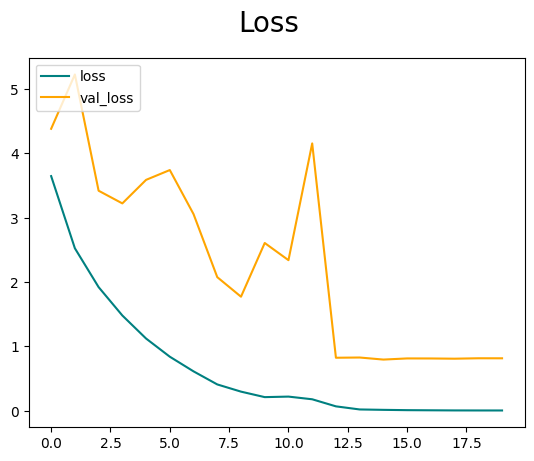

In [15]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

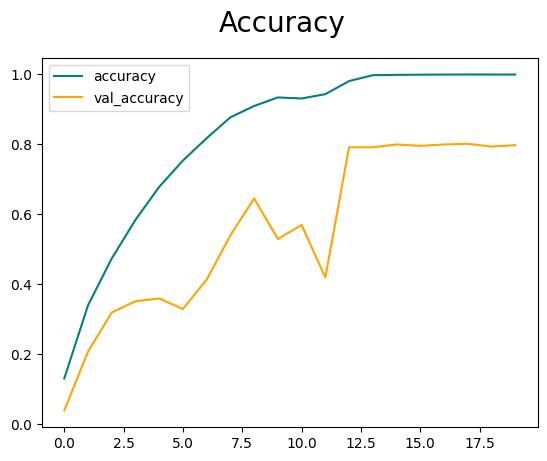

In [16]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [17]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()


In [18]:
for batch in testing_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision:0.8648648858070374, Recall:0.8320000171661377, Accuracy:0.8500000238418579


In [19]:
# Specify the saving path on your Google Drive
saving_path = '/content/drive/MyDrive/Saved_Models'

# Save the TensorFlow model
tf.saved_model.save(model, saving_path)

In [21]:
model.save('Sport_model.keras')